## 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.1 MB/s eta 0:00:00


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [ ]:
#load ffhq stylegan model

import pickle
%cd /content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify

ffhq = '/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/ffhq.pkl'

with open(ffhq, 'rb') as f:
    ffhq = pickle.load(f)['G_ema'].requires_grad_(False).to(device) #.cuda()  # torch.nn.Module ##FFHQ model

/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify


In [ ]:
%cd /content/drive/MyDrive/VToonify

/content/drive/MyDrive/VToonify


In [ ]:
import ninja
from torchvision import transforms
import torchvision
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import os
import warnings
import copy
import numpy as np
import math

import argparse
import cv2
import dlib
import torch.nn.functional as F
from tqdm import tqdm
from model.vtoonify import VToonify
from model.bisenet.model import BiSeNet
from model.encoder.align_all_parallel import align_face
from util import save_image, load_image, visualize, load_psp_standalone, get_video_crop_parameter, tensor2cv2

warnings.filterwarnings('ignore')

## VToonify

### argparser

In [ ]:
args = argparse.Namespace(
    backbone='dualstylegan',
    faceparsing_path='./checkpoint/faceparsing.pth',
    style_encoder_path='./checkpoint/encoder.pt',
    exstyle_path='/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/vtoonify_d_pixar/exstyle_code.npy',
    style_id=26,
    content='/content/drive/MyDrive/pytorch-CycleGAN-and-pix2pix/checkpoints/metfaces_pix2pix_3/web/images/epoch001_real_A.png',
    output_path= './output/ffhq_pixar',
    scale_image= True,
    padding= [200,200,200,200],
    color_transfer= False,
    style_degree= 0.5,
)

### VToonify Model Load

*   _sXXX: supports only one fixed style with XXX the index of this style.
*   _s without XXX means the model supports examplar-based style transfer
*   _dXXX: supports only a fixed style degree of XXX.
*   _d without XXX means the model supports style degrees ranging from 0 to 1
*   _c: supports color transfer.

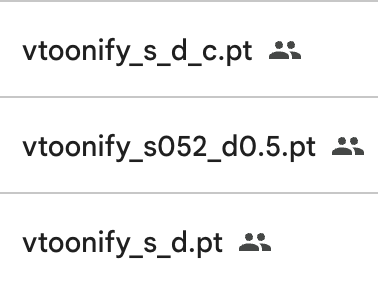

In [ ]:
path = '/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/vtoonify_d_caricature/'
#pt = 'vtoonify_s004_d_c.pt'
#pt = 'vtoonify_s009_d_c.pt'
#pt = 'vtoonify_s043_d_c.pt'
#pt = 'vtoonify_s050_d_c.pt'
#pt = 'vtoonify_s054_d_c.pt'
pt = 'vtoonify_s039_d.pt'
#vtoonify_s039_d0.5.pt
#vtoonify_s068_d0.5.pt
vtoonify = VToonify(backbone = args.backbone)
vtoonify.load_state_dict(torch.load(path+pt, map_location=lambda storage, loc: storage)['g_ema'])
vtoonify.to(device)

VToonify(
  (generator): DualStyleGAN(
    (style): Sequential(
      (0): PixelNorm()
      (1): EqualLinear(512, 512)
      (2): EqualLinear(512, 512)
    )
    (generator): Generator(
      (style): Sequential(
        (0): PixelNorm()
        (1): EqualLinear(512, 512)
        (2): EqualLinear(512, 512)
        (3): EqualLinear(512, 512)
        (4): EqualLinear(512, 512)
        (5): EqualLinear(512, 512)
        (6): EqualLinear(512, 512)
        (7): EqualLinear(512, 512)
        (8): EqualLinear(512, 512)
      )
      (input): ConstantInput()
      (conv1): StyledConv(
        (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
        (noise): NoiseInjection()
        (activate): FusedLeakyReLU()
      )
      (to_rgb1): ToRGB(
        (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
      )
      (convs): ModuleList(
        (0): StyledConv(
          (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
          (noise

### extra models load



*   BiSeNet : Semantic Segmentation Model



In [ ]:
parsingpredictor = BiSeNet(n_classes=19)
parsingpredictor.load_state_dict(torch.load(args.faceparsing_path, map_location=lambda storage, loc: storage))
parsingpredictor.to(device).eval()

modelname = './checkpoint/shape_predictor_68_face_landmarks.dat'

landmarkpredictor = dlib.shape_predictor(modelname)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [ ]:
pspencoder = load_psp_standalone(args.style_encoder_path, device)

if args.backbone == 'dualstylegan':
    exstyles = np.load(args.exstyle_path, allow_pickle='TRUE').item()
    stylename = list(exstyles.keys())[args.style_id]
    exstyle = torch.tensor(exstyles[stylename]).to(device)
    with torch.no_grad():
        exstyle = vtoonify.zplus2wplus(exstyle)

print('Load models successfully!')


filename = args.content
basename = os.path.basename(filename).split('.')[0]
scale = 1
kernel_1d = np.array([[0.125],[0.375],[0.375],[0.125]])
print('Processing ' + os.path.basename(filename) + ' with vtoonify_' + args.backbone[0])

Load models successfully!
Processing epoch001_real_A.png with vtoonify_d


### Make FFHQ faces

In [ ]:
def make_face():
  z = torch.randn([1, ffhq.z_dim],device=device)
  ws = ffhq.mapping(z,None,truncation_psi=0.5, truncation_cutoff=8)
  img_ori = ffhq.synthesis(ws, noise_mode='const', force_fp32=True)
  img_ori=img_ori.to('cpu')
  img_ori = np.array(img_ori[0].permute(1,2,0))

  return img_ori

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

Done.


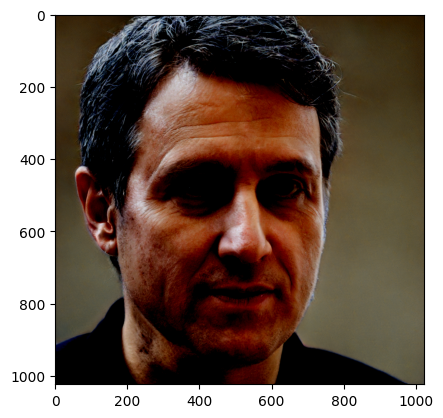

In [ ]:
plt.imshow(make_face())

In [ ]:
def norm_resize(img):
  normalized_data = (np.array(img) - np.min(img)) / (np.max(img) - np.min(img))
  normalized_data = (normalized_data * 255).astype(np.uint8)
  frame = cv2.resize(normalized_data,(512,512))

  return frame

### transform

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5,0.5,0.5]),
        ])

topil = transforms.ToPILImage(mode = 'RGB')

In [ ]:
def make_pair(ori,trans):
  concatenated_image = Image.new('RGB', (1024, 512))
  concatenated_image.paste(ori, (0, 0))
  concatenated_image.paste(trans, (512, 0))
  return concatenated_image

In [ ]:
def imshow(ori,trans):
  trans = ((trans)*0.5+0.5).permute(1,2,0)

  fig,axes = plt.subplots(1,2,figsize=(10,10))
  axes[0].imshow(ori)
  axes[1].imshow(trans)

In [ ]:
def toonify(arg, frame):

  # cropname = os.path.join(args.output_path, basename + '_input.jpg')
  # savename = os.path.join(args.output_path, basename + '_vtoonify_' +  args.backbone[0] + '.jpg')


  # frame = cv2.imread(filename)
  # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

  # We detect the face in the image, and resize the image so that the eye distance is 64 pixels.
  # Centered on the eyes, we crop the image to almost 400x400 (based on args.padding).
  if args.scale_image:
      paras = get_video_crop_parameter(frame, landmarkpredictor, args.padding)
      if paras is not None:
          h,w,top,bottom,left,right,scale = paras
          H, W = int(bottom-top), int(right-left)
          # for HR image, we apply gaussian blur to it to avoid over-sharp stylization results
          if scale <= 0.75:
              frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
          if scale <= 0.375:
              frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
          frame = cv2.resize(frame, (w, h))[top:bottom, left:right]

  with torch.no_grad():
      I = align_face(frame, landmarkpredictor)
      I = transform(I).unsqueeze(dim=0).to(device)
      s_w = pspencoder(I)
      s_w = vtoonify.zplus2wplus(s_w)
      if vtoonify.backbone == 'dualstylegan':
          if args.color_transfer:
              s_w = exstyle
          else:
              s_w[:,:7] = exstyle[:,:7]

      x = transform(frame).unsqueeze(dim=0).to(device)
      # parsing network works best on 512x512 images, so we predict parsing maps on upsmapled frames
      # followed by downsampling the parsing maps
      x_p = F.interpolate(parsingpredictor(2*(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)))[0],
                          scale_factor=0.5, recompute_scale_factor=False).detach()
      # we give parsing maps lower weight (1/16)
      inputs = torch.cat((x, x_p/16.), dim=1)
      # d_s has no effect when backbone is toonify
      y_tilde = vtoonify(inputs, s_w.repeat(inputs.size(0), 1, 1), d_s = args.style_degree)
      y_tilde = torch.clamp(y_tilde, -1, 1)

  #frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  trans = y_tilde[0].cpu()
  trans = ((trans)*0.5+0.5)#.permute(1,2,0)
  trans = topil(trans)

  return frame, trans

In [ ]:
os.makedirs('./output/ffhq_cartoon_512/',exist_ok=True)

In [ ]:
from tqdm import tqdm

In [ ]:
#cartoon
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#caricature #1
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#comic
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#illu1
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#illu2
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#illu3
passed = 0
for num in tqdm(range(0,10)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  plt.imshow(pair)
  plt.show()

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
passed = 0
for num in tqdm(range(0,5000)):
  ori = make_face()
  ori = norm_resize(ori)
  try:
    ori, trans = toonify(args,ori)
  except:
    passed+=1
    continue
  ori = Image.fromarray(ori)
  ori = ori.resize((512,512))
  trans = trans.resize((512,512))
  pair = make_pair(ori,trans)
  if num%100==0:
    plt.imshow(pair)
    plt.show()
  pair.save(f'./output/ffhq_cartoon_512/{num}.jpg')

print('Passed {}'.format(passed))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ori = np.array(Image.open('/content/drive/MyDrive/VToonify/output/close_eyes.jpeg'))

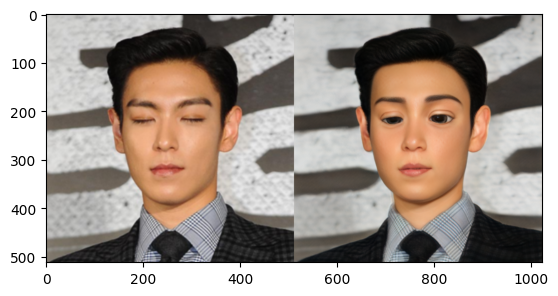

In [ ]:
#Color transfer False
ori, trans = toonify(args,ori)
ori = Image.fromarray(ori)
ori = ori.resize((512,512))
trans = trans.resize((512,512))
pair = make_pair(ori,trans)
plt.imshow(pair)
plt.show()

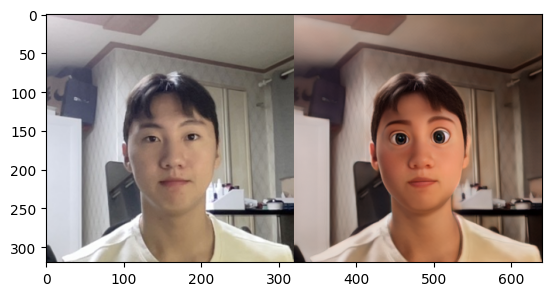

In [ ]:
#Color transfer True
ori, trans = toonify(args,ori)
ori = Image.fromarray(ori)
ori = ori.resize((320,320))
trans = trans.resize((320,320))
pair = make_pair(ori,trans)
plt.imshow(pair)
plt.show()